In [3]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math

In [231]:
def detect_roi(image, visualize_bounding_box=False):
    """Detect the ROI surrounding the barcode in the given image.

    It returns the bounding box coordinates. In addition, it warps the bounding box, in order to rotate it and making the 
    bars perfectly vertical.

    This works both if the barcode is non-rotated (i.e. the bars are vertical) and if the barcode is rotated (i.e. the bars 
    are horizontal). 

    Parameters
    ----------
    image : np.array
        Input image.
    visualize_bounding_box : bool, optional
        Whether to visualize or not the input image with the detected bounding box, by default False
    visualize_final_image : bool, optional
        Whether to visualize or not the warped bounding box, by default False

    Returns
    -------
    bb_sorted : np.array
        Array 4x2, containing the coordinates of the four bounding box points. 
        The points are ordered in the following way: up-left, up-right, bottom-left, bottom-right.
    
    bb_image_warped : np.array
        Image representing the warped bounding box: the barcode bars are perfectly vertical.

    rotated : bool
        Whether the barcode was non-rotated (i.e. the bars were vertical) or rotated (i.e. the bars were horizontal).

    """

    # Convert the image to grey scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute both the horizontal and vertical derivative, using the Sobel filter
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    # Subtract the y-gradient from the x-gradient: we get the final gradient image
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # Blur the gradient image    
    blurred = cv2.blur(gradient, (9, 9))

    # Threshold the gradient image
    _ ,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Closing: fill the bounding box
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Opening: remove small things outside
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    # Dilate: slight enlarge the box
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    dilated = cv2.dilate(opened, kernel, iterations=3)
    
    # Find the bounding box (OpenCV API)
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # Compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    # This is our bounding box: 4 points, each of them 2 coordinates
    box = np.int0(box)  

    if visualize_bounding_box:
        # Draw a bounding box around the detected barcode and display the image
        image_bb = image.copy()
        cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
        plt.figure()
        plt.imshow(image_bb, 'gray')
        plt.title('Original image, with the bounding box')
    
    # Sorting the points of the bounding box, such that they follow the ordering: up-left, up-right, bottom-left, bottom-right.
    bb_sorted = box.astype('float32')
    min_width = bb_sorted[:,0].min()
    min_height = bb_sorted[:,1].min()
    max_width = bb_sorted[:,0].max()
    max_height = bb_sorted[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    bb_sorted = np.array(sorted([tuple(v) for v in bb_sorted], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    
    # Compute the width and height of the bounding box.
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    bb_height = int(max([dist(bb_sorted[0],bb_sorted[2]),
                             dist(bb_sorted[1],bb_sorted[3])]))
    bb_width = int(max([dist(bb_sorted[0],bb_sorted[1]),
                             dist(bb_sorted[2],bb_sorted[3])]))


    return bb_sorted, bb_width, bb_height

In [55]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

In [56]:
image_path = 'images/EAN-UPC-EAN-13 MASTER GRADE IMGB.bmp' # C39_4.4LOW  C39_7.5UP  EAN128-DEFECTS IMGB  EAN128-MASTER IMGB  EAN-UPC-EAN-13 MASTER GRADE IMGB

In [57]:
image_path = f'../images/{images_paths[26]}'#'other images/1.png'#f'images/{images_paths[22]}'

(1024, 1280, 3)


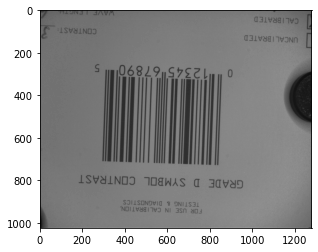

In [58]:
# load the image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')

array([[296., 246.],
       [873., 265.],
       [280., 726.],
       [857., 745.]], dtype=float32)

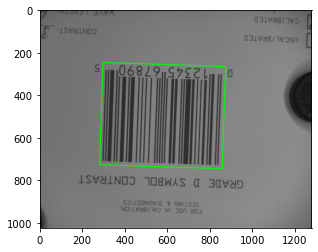

In [59]:
bb_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
bb_sorted

## ROTATING THE IMAGE

In [60]:
point1 = bb_sorted[0, :]
point2 = bb_sorted[1, :]
point3 = bb_sorted[2, :]
point4 = bb_sorted[3, :]

In [61]:
import math

angle1 = math.atan((point2[1]-point1[1])/(point2[0]-point1[0]))
angle1 = round(math.degrees(angle1))  
print(math.degrees(angle1))
if angle1<0:        
  angle1 = 180+angle1  
print(angle1)
print(abs(math.degrees(math.atan((point2[1]-point1[1])/(point2[0]-point1[0])))))

angle2 = math.atan((point4[1]-point3[1])/(point4[0]-point3[0]))
print(angle2)

114.59155902616465
2
1.8860080152490561
0.03291704958509945


In [62]:
angle1 = abs(math.degrees(math.atan((point2[1]-point1[1])/(point2[0]-point1[0]))))
print(angle1)

angle2 = abs(math.degrees(math.atan((point4[1]-point3[1])/(point4[0]-point3[0]))))
print(angle2)

angle3 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))
print(angle3)

angle4 = 90-abs(math.degrees(math.atan((point2[1]-point4[1])/(point2[0]-point4[0]))))
print(angle4)

1.8860080152490561
1.8860080152490561
1.909152432996379
1.909152432996379


In [63]:
def rotate_image(image, angle, center):
  #image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result, rot_mat

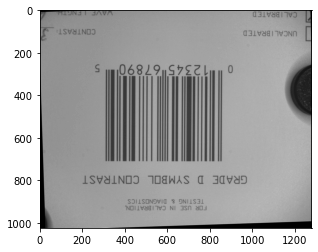

In [83]:
gray_rot, rot_mat = rotate_image(gray, angle=angle1, center=point1)
plt.imshow(gray_rot, 'gray')

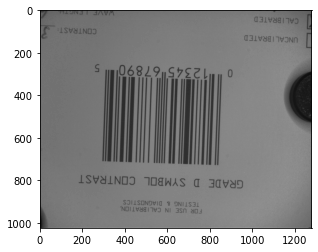

In [84]:
plt.imshow(gray, 'gray')

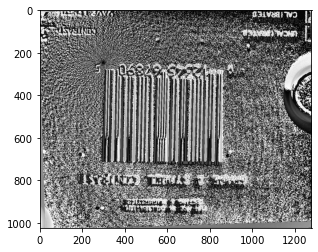

In [85]:
plt.imshow(abs(gray_rot-gray), 'gray')

In [203]:
bb_sorted_rot = np.array([point1,
                          [point1[0]+bb_width-1,point1[1]],
                          [point1[0],point1[1]+bb_height-1],
                          [point1[0]+bb_width-1,point1[1]+bb_height-1]], dtype='float32') 
bb_rot = np.array([point1,
                  [point1[0]+bb_width-1,point1[1]],
                  [point1[0]+bb_width-1,point1[1]+bb_height-1],
                  [point1[0],point1[1]+bb_height-1]], dtype='float32') 

In [184]:
bb_sorted_rot

array([[296., 246.],
       [872., 246.],
       [296., 725.],
       [872., 725.]], dtype=float32)

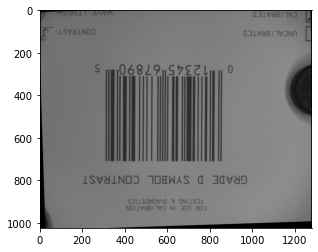

In [185]:
image_rot, rot_mat = rotate_image(image, angle=angle1, center=point1)
plt.imshow(image_rot, 'gray')

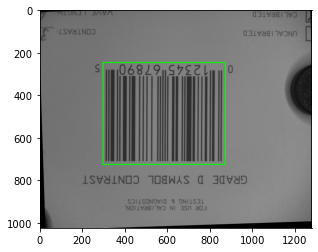

In [204]:
# Draw a bounding box around the detected barcode and display the image
image_rot_bb = image_rot.copy()
cv2.drawContours(image_rot_bb, [bb_rot.astype(int)], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_rot_bb, 'gray')

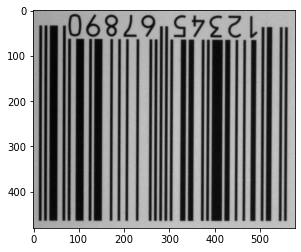

In [187]:
roi_image = gray_rot[int(bb_sorted_rot[0][1]):int(bb_sorted_rot[0][1]+bb_height), int(bb_sorted_rot[0][0]):int(bb_sorted_rot[0][0]+bb_width)]
plt.figure()
plt.imshow(roi_image, 'gray')

## COMPUTING THE X DIMENSION AND THE MINIMUM HEIGHT

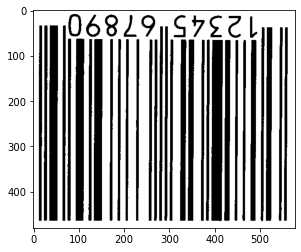

In [146]:
_ ,thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#thresh = 255-thresh

plt.imshow(thresh, 'gray')

DELETE FROM HERE...

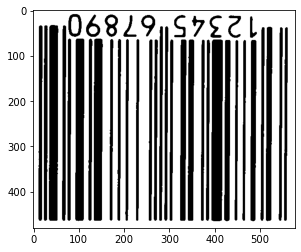

In [145]:
blurred = cv2.blur(roi_image, (5,5))
_ ,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#thresh = 255-thresh

plt.imshow(thresh, 'gray')

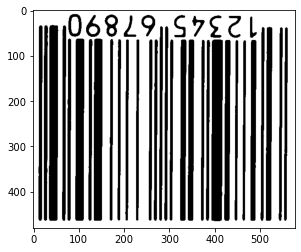

In [152]:
blurred = cv2.bilateralFilter(roi_image,9,80,80)
_ ,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#thresh = 255-thresh

plt.imshow(thresh, 'gray')

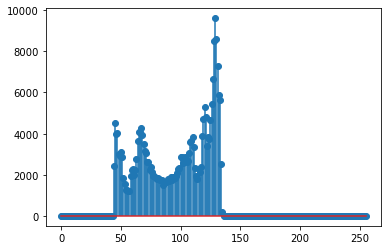

In [153]:
hist, bins = np.histogram(cv2.bilateralFilter(roi_image,9,80,80).flatten(),256,[0,256])
plt.stem(hist, use_line_collection=True)
plt.show()

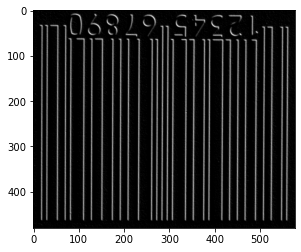

In [139]:
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(roi_image, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(roi_image, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# Subtract the y-gradient from the x-gradient: we get the final gradient image
gradient = cv2.subtract(gradX, gradY)
#gradient = cv2.convertScaleAbs(gradient)
gradient[gradient<0] = 0

plt.imshow(gradient, 'gray')

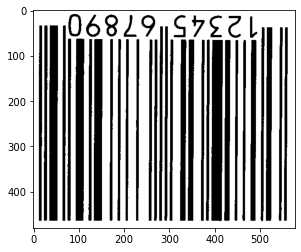

In [113]:
_ ,thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#thresh = 255-thresh

plt.imshow(thresh, 'gray')

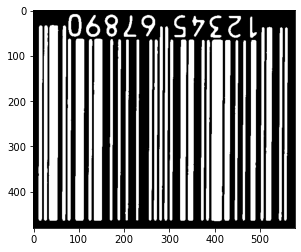

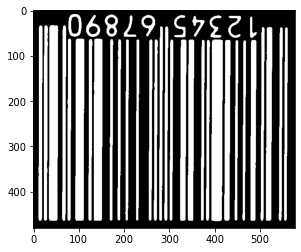

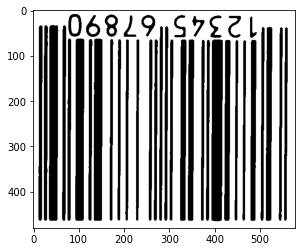

In [156]:
thresh_inv = 255-thresh
plt.figure()
plt.imshow(thresh_inv, 'gray')

# Making bars more vertical (fill possible holes)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
closed_inv = cv2.morphologyEx(thresh_inv, cv2.MORPH_CLOSE, kernel)
plt.figure()
plt.imshow(closed_inv, 'gray')

closed = 255-closed_inv
plt.figure()
plt.imshow(closed, 'gray')

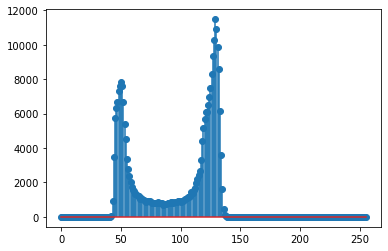

In [142]:
hist, bins = np.histogram(roi_image.flatten(),256,[0,256])
plt.stem(hist, use_line_collection=True)
plt.show()

... TO HERE

In [114]:
half_height = int(bb_height/2)

In [115]:
half_height, bb_width

(240, 577)

In [116]:
roi_image.shape

(480, 577)

In [117]:
thresh.shape

(480, 577)

In [118]:
first_bar_found = False
X = bb_width

min_half_height_up = half_height
min_half_height_bottom = half_height

i = 0
while i<bb_width:
    if thresh[half_height, i]==255:
        print('W', end='')
        i += 1
        continue
    
    print('B', end='')
    if not first_bar_found:
        first_bar_x = i
        first_bar_found = True 
        
    X_tmp = 0
    j = i+1
    while thresh[half_height, j]==0:
        print('B', end='')
        X_tmp += 1
        j += 1
    if X_tmp<X:
        X = X_tmp
       
    j_up = half_height-1
    j_bottom = half_height+1
    min_half_height_up = 0
    min_half_height_bottom = 0
    while thresh[j_up, i]==0 or thresh[j_bottom, i]==0:
        if thresh[j_up, i]==0:
            j_up -= 1
            min_half_height_up += 1
        if thresh[j_bottom, i]==0:
            j_bottom += 1
            min_half_height_bottom += 1
            
    i = j

WWWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBWWWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWWWWWWWBBBBBWWWWWWWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBWWWWWWWWWWWWWWWWWBBBBBBBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWBBBBBWWWWWWWWWWWWBBBBBBBBBBBWWWWWWWWWWWWBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBWWWWWWBBBBBBWWWWWWWWWWWWWWWWW

In [140]:
print(first_bar_found)

print(first_bar_x)

print(X)

print(min_half_height_up)

print(min_half_height_bottom)

True
13
4
69
223


In [121]:
len('WWWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBWWWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWWWWWWWBBBBBWWWWWWWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBWWWWWWWWWWWWWWWWWBBBBBBBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWBBBBBBWWWWWWBBBBBBBBBBBBBBBBBBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWWWBBBBBWWWWWWWWWWWWBBBBBBBBBBBWWWWWWWWWWWWBBBBBBWWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBWWWWWWBBBBBBWWWWWWWWWWWWWWWWW')

577

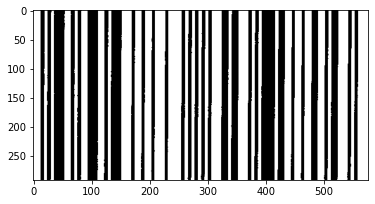

In [124]:
thresh_sub = thresh[half_height-min_half_height_up:-(half_height-min_half_height_bottom),:]

plt.imshow(thresh_sub, 'gray')

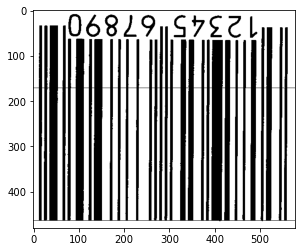

In [126]:
thresh_temp = thresh.copy()
thresh_temp[half_height-min_half_height_up,:] = 0
thresh_temp[-(half_height-min_half_height_bottom),:] = 0
plt.imshow(thresh_temp, 'gray')

**PROBLEM:** the bars are not perfectly black, there can be some white pixels, which negatively affect the behaviour of the algorithm. 

### Fixing the problem

In [174]:
first_bar_found = False
X = bb_width

min_half_height_up = half_height
min_half_height_bottom = half_height

i = 0
while i<bb_width:
    if thresh[half_height, i]==255:
        print('W', end='')
        i += 1
        continue
    
    print('B', end='')
    if not first_bar_found:
        first_bar_x = i
        first_bar_found = True 
        
    X_curr = 0
    j = i+1
    while thresh[half_height, j]==0:
        print('B', end='')
        X_curr += 1
        j += 1
       
    j_up = half_height-1
    j_bottom = half_height+1
    min_half_height_up_curr = 0
    min_half_height_bottom_curr = 0
    
    up_reached = False
    bottom_reached = False
    
    while not up_reached or not bottom_reached:
        X_tmp_up = X_curr
        X_tmp_bottom = X_curr
        
        while thresh[j_up, j]==0:
            X_tmp_up += 1
            j +=1 
        while thresh[j_bottom, j]==0:
            X_tmp_bottom += 1
            j +=1 
        X_curr = max([X_tmp_up,X_tmp_bottom])
            
        up_reached = np.all(thresh[j_up, i:j]==255)
        if not up_reached:
            j_up -= 1
            min_half_height_up_curr += 1
        
        bottom_reached = np.all(thresh[j_bottom, i:j]==255)
        if not bottom_reached:
            j_bottom += 1
            min_half_height_bottom_curr += 1
            
    if X_curr<X:
        X = X_curr
        
    if min_half_height_up_curr<min_half_height_up:
        min_half_height_up = min_half_height_up_curr
        
    if min_half_height_bottom_curr<min_half_height_bottom:
        min_half_height_bottom = min_half_height_bottom_curr
            
    i = j
    
last_bar_x = j - 1

WWWWWWWWWWWWWBBBBBBBWWWBBBBBBBBWWWBBBBBBBBBBBBBBBBBBBWWWWWWWWWBBBBBBBWWWBBBBBBBBWWWWWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWBBBBBBBWWWBBBBBBBBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBBWWWWBBBBBBWWWWBBBBBBBWWWWBBBBBBWWWWWWWWWWWWWWWWBBBBBBBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBWWWWBBBBBBBBBBBBBBBBBBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBWWWWWWWWWWWBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBWWWWWWWWWWWWWWWW

In [175]:
print(first_bar_found)

print(first_bar_x)

print(last_bar_x)

print(X)

print(min_half_height_up)

print(min_half_height_bottom)

True
13
560
5
173
223


In [165]:
len('WWWWWWWWWWWWWBBBBBBBWWWBBBBBBBBWWWBBBBBBBBBBBBBBBBBBBWWWWWWWWWBBBBBBBWWWBBBBBBBBWWWWWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWBBBBBBBWWWBBBBBBBBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBBWWWWBBBBBBWWWWBBBBBBBWWWWBBBBBBWWWWWWWWWWWWWWWWBBBBBBBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBWWWWBBBBBBBBBBBBBBBBBBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBWWWWWWWWWWWBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBWWWWWWWWWWWWWWWW')

548

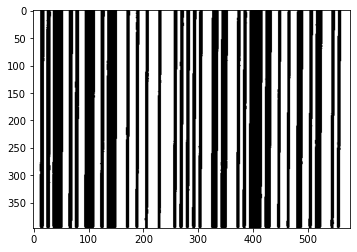

In [166]:
thresh_sub = thresh[half_height-min_half_height_up:-(half_height-min_half_height_bottom),:]

plt.imshow(thresh_sub, 'gray')

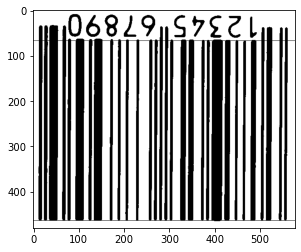

In [167]:
thresh_temp = thresh.copy()
thresh_temp[half_height-min_half_height_up,:] = 0
thresh_temp[-(half_height-min_half_height_bottom),:] = 0
plt.imshow(thresh_temp, 'gray')

## REFINING THE ROI

In [206]:
bb_sorted_rot

array([[296., 246.],
       [872., 246.],
       [296., 725.],
       [872., 725.]], dtype=float32)

In [199]:
bb_width-last_bar_x

17

In [200]:
10*X-(bb_width-last_bar_x)

33

In [198]:
(10*X-(bb_width-last_bar_x)) 

33

In [205]:
bb_sorted_rot_ref = bb_sorted_rot.copy()
bb_sorted_rot_ref[[0,2],0] = bb_sorted_rot[[0,2],0] - (10*X-first_bar_x) 
bb_sorted_rot_ref[[1,3],0] = bb_sorted_rot[[1,3],0] + (10*X-(bb_width-last_bar_x)) 

bb_sorted_rot_ref

array([[259., 246.],
       [905., 246.],
       [259., 725.],
       [905., 725.]], dtype=float32)

In [207]:
bb_rot_ref = bb_sorted_rot_ref.copy()
bb_rot_ref[2, :] = bb_sorted_rot_ref[3, :]
bb_rot_ref[3, :] = bb_sorted_rot_ref[2, :]
bb_rot_ref

array([[259., 246.],
       [905., 246.],
       [905., 725.],
       [259., 725.]], dtype=float32)

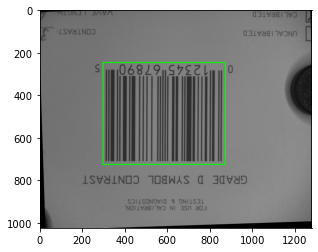

In [208]:
# Draw a bounding box around the detected barcode and display the image
image_rot_bb = image_rot.copy()
cv2.drawContours(image_rot_bb, [bb_rot.astype(int)], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_rot_bb, 'gray')

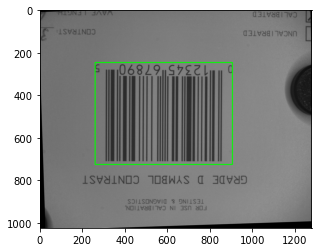

In [209]:
# Draw a bounding box around the detected barcode and display the image
image_rot_bb = image_rot.copy()
cv2.drawContours(image_rot_bb, [bb_rot_ref.astype(int)], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_rot_bb, 'gray')

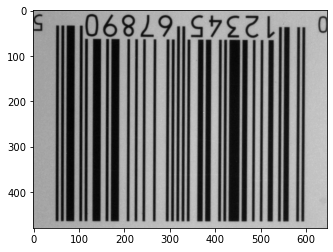

In [213]:
roi_image_ref = gray_rot[int(bb_sorted_rot_ref[0][1]):int(bb_sorted_rot_ref[2][1]), int(bb_sorted_rot_ref[0][0]):int(bb_sorted_rot_ref[1][0])]
plt.figure()
plt.imshow(roi_image_ref, 'gray')

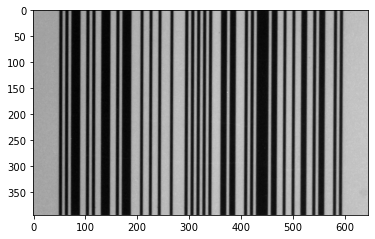

In [214]:
roi_image_ref = roi_image_ref[half_height-min_half_height_up:-(half_height-min_half_height_bottom),:]
plt.figure()
plt.imshow(roi_image_ref, 'gray')

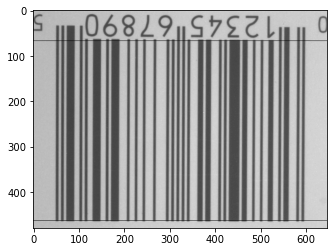

In [216]:
roi_image_temp = roi_image.copy()
roi_image_temp[half_height-min_half_height_up,:] = 0
roi_image_temp[-(half_height-min_half_height_bottom),:] = 0
plt.imshow(roi_image_temp, 'gray')

## DEFINING A FUNCTION

In [220]:
def rotate_image(image, angle, center):
  #image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result, rot_mat

In [221]:
def rotate_image_boundingBox(image, bb_sorted, bb_width, bb_height):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    point1 = bb_sorted[0, :]
    point2 = bb_sorted[1, :]
    point3 = bb_sorted[2, :]
    point4 = bb_sorted[3, :]
    
    angle = abs(math.degrees(math.atan((point2[1]-point1[1])/(point2[0]-point1[0]))))
    """ TODO : CONSIDER THE OTHER ANGLES?
    angle2 = abs(math.degrees(math.atan((point4[1]-point3[1])/(point4[0]-point3[0]))))
    #print(angle2)
    angle3 = 90-abs(math.degrees(math.atan((point1[1]-point3[1])/(point1[0]-point3[0]))))
    #print(angle3)
    angle4 = 90-abs(math.degrees(math.atan((point2[1]-point4[1])/(point2[0]-point4[0]))))
    #print(angle4)"""
    
    gray_rot, rot_mat = rotate_image(gray, angle=angle1, center=point1)
    """plt.figure()
    plt.imshow(gray_rot, 'gray')
    plt.title('Rotated image')"""
    
    bb_sorted_rot = np.array([point1,
                          [point1[0]+bb_width-1,point1[1]],
                          [point1[0],point1[1]+bb_height-1],
                          [point1[0]+bb_width-1,point1[1]+bb_height-1]], dtype='float32') 
    bb_rot = bb_sorted_rot.copy()
    bb_rot[2, :] = bb_sorted_rot[3, :]
    bb_rot[3, :] = bb_sorted_rot[2, :]
    
    image_rot, rot_mat = rotate_image(image, angle=angle1, center=point1)
    image_rot_bb = image_rot.copy()
    cv2.drawContours(image_rot_bb, [bb_rot.astype(int)], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_rot_bb, 'gray')
    plt.title('Rotated image, with the rotated bounding box')
    
    return image_rot, gray_rot, bb_sorted_rot, bb_rot

In [222]:
def computing_roi_quantities(roi_image):
    _ ,thresh = cv2.threshold(roi_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    half_height = int(bb_height/2)
    
    first_bar_found = False
    X = bb_width

    min_half_height_up = half_height
    min_half_height_bottom = half_height

    i = 0
    while i<bb_width:
        if thresh[half_height, i]==255:
            print('W', end='')
            i += 1
            continue

        print('B', end='')
        if not first_bar_found:
            first_bar_x = i
            first_bar_found = True 

        X_curr = 0
        j = i+1
        while thresh[half_height, j]==0:
            print('B', end='')
            X_curr += 1
            j += 1

        j_up = half_height-1
        j_bottom = half_height+1
        min_half_height_up_curr = 0
        min_half_height_bottom_curr = 0

        up_reached = False
        bottom_reached = False

        while not up_reached or not bottom_reached:
            X_tmp_up = X_curr
            X_tmp_bottom = X_curr

            while thresh[j_up, j]==0:
                X_tmp_up += 1
                j +=1 
            while thresh[j_bottom, j]==0:
                X_tmp_bottom += 1
                j +=1 
            X_curr = max([X_tmp_up,X_tmp_bottom])

            up_reached = np.all(thresh[j_up, i:j]==255)
            if not up_reached:
                j_up -= 1
                min_half_height_up_curr += 1

            bottom_reached = np.all(thresh[j_bottom, i:j]==255)
            if not bottom_reached:
                j_bottom += 1
                min_half_height_bottom_curr += 1

        if X_curr<X:
            X = X_curr

        if min_half_height_up_curr<min_half_height_up:
            min_half_height_up = min_half_height_up_curr

        if min_half_height_bottom_curr<min_half_height_bottom:
            min_half_height_bottom = min_half_height_bottom_curr

        i = j

    last_bar_x = j - 1
    
    return first_bar_x, last_bar_x, X, min_half_height_up, min_half_height_bottom 

In [229]:
def refine_roi(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #print(image.shape)
    plt.figure()
    plt.imshow(gray, 'gray')
    plt.title('Original image')
    
    bb_sorted, bb_width, bb_height = detect_roi(image, visualize_bounding_box=True)
    
    image_rot, gray_rot, bb_sorted_rot, bb_rot = rotate_image_boundingBox(image, bb_sorted, bb_width, bb_height)
    
    roi_image = gray_rot[int(bb_sorted_rot[0][1]):int(bb_sorted_rot[0][1]+bb_height), int(bb_sorted_rot[0][0]):int(bb_sorted_rot[0][0]+bb_width)]
    
    first_bar_x, last_bar_x, X, min_half_height_up, min_half_height_bottom  = computing_roi_quantities(roi_image)
    
    bb_sorted_rot_ref = bb_sorted_rot.copy()
    bb_sorted_rot_ref[[0,2],0] = bb_sorted_rot[[0,2],0] - (10*X-first_bar_x) 
    bb_sorted_rot_ref[[1,3],0] = bb_sorted_rot[[1,3],0] + (10*X-(bb_width-last_bar_x)) 

    bb_rot_ref = bb_sorted_rot_ref.copy()
    bb_rot_ref[2, :] = bb_sorted_rot_ref[3, :]
    bb_rot_ref[3, :] = bb_sorted_rot_ref[2, :]
    
    # Draw a bounding box around the detected barcode and display the image
    image_rot_bb = image_rot.copy()
    cv2.drawContours(image_rot_bb, [bb_rot_ref.astype(int)], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_rot_bb, 'gray')
    plt.title('Refined bounding box')
    
    roi_image_ref_tmp = gray_rot[int(bb_sorted_rot_ref[0][1]):int(bb_sorted_rot_ref[2][1]), int(bb_sorted_rot_ref[0][0]):int(bb_sorted_rot_ref[1][0])]
    roi_image_ref = roi_image_ref_tmp[half_height-min_half_height_up:-(half_height-min_half_height_bottom),:]
    plt.figure()
    plt.imshow(roi_image_ref, 'gray')
    plt.title('Refined ROI')
    
    roi_image_temp = roi_image_ref_tmp.copy()
    roi_image_temp[half_height-min_half_height_up,:] = 0
    roi_image_temp[-(half_height-min_half_height_bottom),:] = 0
    plt.figure()
    plt.imshow(roi_image_temp, 'gray')

WWWWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWBBBBBBBWWWWWBBBBBBWWWWWWWWWWBBBBBBBBBBBBBBBBBBWWWWWWWWWWBBBBBBWWWWWBBBBBBBBBBBBBBBBBWWWWWWWWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWWWWWWWWBBBBBWWWWWWWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBWWWWWBBBBBBWWWWBBBBBBWWWWWBBBBBBWWWWWWWWWWWWWWWWBBBBBBBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWBBBBBBWWWWBBBBBBWWWWWBBBBBBBBBBBBBBBBBBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWBBBBBBWWWWWWWWWWWBBBBBWWWWWWWWWWWBBBBBBBBBBBWWWWWWWWWWWBBBBBBWWWWBBBBBBBBBBBBWWWWWWWWWWWWWWWWBBBBBWWWWBBBBBBWWWWWWWWWWWWWWWW

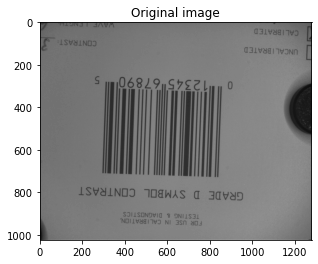

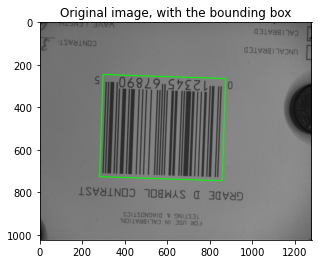

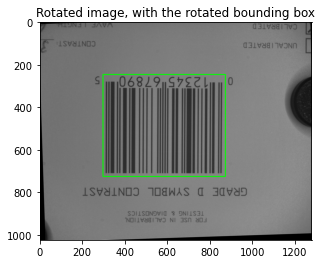

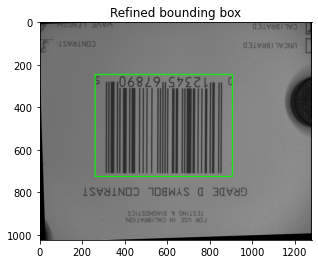

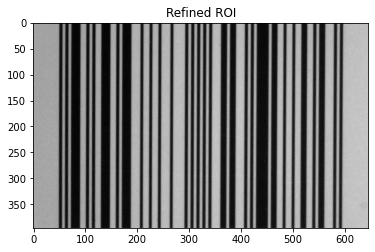

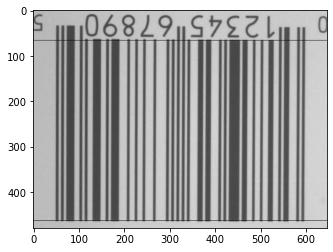

In [232]:
refine_roi(image_path)